In [1]:
# * * * * * * * * * * * * * * * *
# Configuration
# * * * * * * * * * * * * * * * *
EXPERIMENT_NUM='100'

DATASET_DIR = '/workspace/datasets'
OUTPUT_DIR = '/workspace/outputs/profiles-v1/profiles-v1-pca'

DEVICE = "cpu"

LATENT_DIM=4
BATCH_SIZE=200
EPOCHS=100
BETA=0.2
LEARNING_RATE=1e-3
GAMMA=0.1

INPUT_DIM=(1,120)

In [2]:
import os
from sklearn.preprocessing import StandardScaler
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torchinfo import summary

from lunar_vae import VAE, train, SampleLatentSpace, VisualizeLatentSpace
from utils import (
    CollectStatisticsFromProfilesV2,
    GenerateDensityPlot,
    GetDataMetrics,
    GetMeanLatentValues,
    LoadProfileList,
    LoadTemperatureDataV2, 
    PlotHistograms,
    PlotLosses,
    PrintAndLog,
    SaveLossesToCSV,
    SetupOutputDir,
    SplitAndNormalizeData,
)

# * * * * * * * * * * * * * * * *
# Setting Variables
# * * * * * * * * * * * * * * * *
INPUT_PT_PATH = f"/workspace/datasets/profiles-v1/profiles-v1-pca/profiles-v1-pca-5-sample-{EXPERIMENT_NUM}.pt"
LABEL = f'profiles_v1_pca_{EXPERIMENT_NUM}'

# * * * * * * * * * * * * * * * *
# Make Directory
# * * * * * * * * * * * * * * * *
model_dir = SetupOutputDir(OUTPUT_DIR, parent_folder=LABEL, sub_folders=["reconstruction_images"])
print(f"Created directory {model_dir}")

Created directory /workspace/outputs/profiles-v1/profiles-v1-pca/profiles_v1_pca_100_20250721_0127


In [3]:
# * * * * * * * * * * * * * * * *
# Load Temp Data
# * * * * * * * * * * * * * * * *
temp_data = torch.load(INPUT_PT_PATH)

Saved figure to /workspace/outputs/profiles-v1/profiles-v1-pca/profiles_v1_pca_100_20250721_0127/density_plot.png


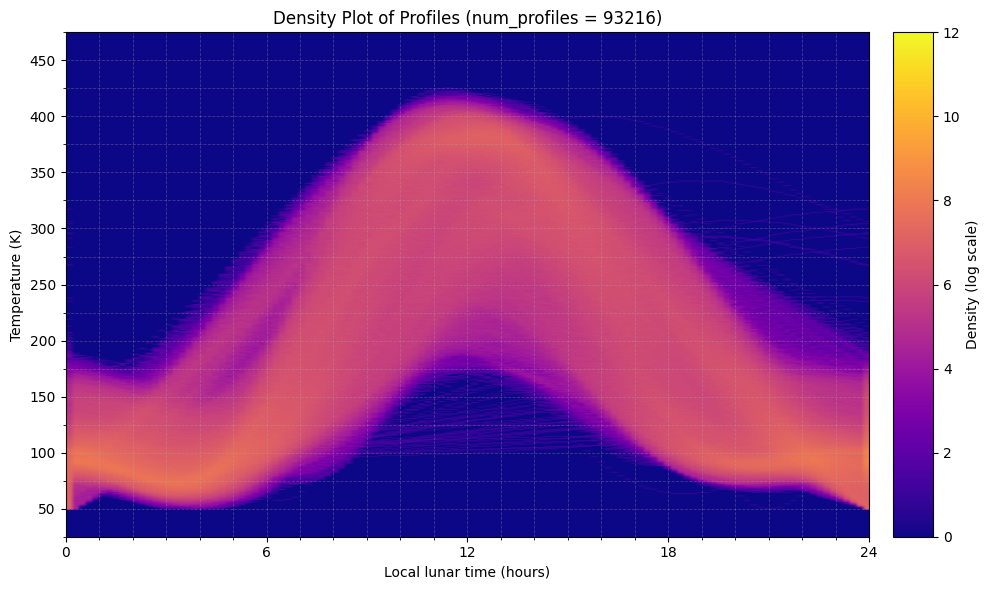

In [4]:
# * * * * * * * * * * * * * * * *
# Generate Density Plot
# * * * * * * * * * * * * * * * *
GenerateDensityPlot(temp_data, model_dir)

In [5]:
# * * * * * * * * * * * * * * * *
# Training Log
# * * * * * * * * * * * * * * * 
log_filepath = os.path.join(model_dir, 'training.log')

# * * * * * * * * * * * * * * * *
# Data Prep
# * * * * * * * * * * * * * * * *
x_data_mean, x_data_std, x_data_min, x_data_max = GetDataMetrics(temp_data)

PrintAndLog(log_filepath, "Data Metrics:\n")
PrintAndLog(log_filepath, f"\tMean: {x_data_mean:.4f}\n")
PrintAndLog(log_filepath, f"\tSTD: {x_data_std:.4f}\n")
PrintAndLog(log_filepath, f"\tMin Temp: {x_data_min:.4f}\n")
PrintAndLog(log_filepath, f"\tMax Temp: {x_data_max:.4f}\n")

# Normalize Data (Mean=0, STD=1)
scaler = StandardScaler()
train_loader, val_loader, test_loader = SplitAndNormalizeData(
	temp_data, scaler, BATCH_SIZE, DEVICE)

PrintAndLog(log_filepath, "Datasets:\n")
PrintAndLog(
	log_filepath,
	f"\tTraining Data: {len(train_loader.dataset)}\n")
PrintAndLog(
	log_filepath,
	f"\tValidation Data: {len(val_loader.dataset)}\n")
PrintAndLog(log_filepath, f"\tTest Data: {len(test_loader.dataset)}\n")

Data Metrics:
Mean: 189.4315
STD: 96.8992
Min Temp: 50.0010
Max Temp: 424.9460
Datasets:
Training Data: 65251
Validation Data: 18643
Test Data: 9322


In [6]:
# * * * * * * * * * * * * * * * *
# VAE Setup
# * * * * * * * * * * * * * * * *
vae = VAE(latent_dim=LATENT_DIM).to(DEVICE)
optimizer = optim.Adam(vae.parameters(), lr=LEARNING_RATE, weight_decay=0)
scheduler = ExponentialLR(optimizer, gamma=GAMMA)

summary(vae, input_size=(BATCH_SIZE, INPUT_DIM[0], INPUT_DIM[1]))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [200, 1, 120]             --
├─Encoder: 1-1                           [200, 4, 1]               --
│    └─Wrap1d: 2-1                       [200, 1, 122]             --
│    └─ConstantPad1d: 2-2                [200, 1, 128]             --
│    └─Conv1d: 2-3                       [200, 32, 128]            128
│    └─BatchNorm1d: 2-4                  [200, 32, 128]            64
│    └─Conv1d: 2-5                       [200, 32, 64]             2,080
│    └─BatchNorm1d: 2-6                  [200, 32, 64]             64
│    └─Conv1d: 2-7                       [200, 32, 32]             2,080
│    └─BatchNorm1d: 2-8                  [200, 32, 32]             64
│    └─Conv1d: 2-9                       [200, 32, 16]             2,080
│    └─BatchNorm1d: 2-10                 [200, 32, 16]             64
│    └─Conv1d: 2-11                      [200, 32, 8]              2,080
│ 

[Training] Epoch 1/100: 100%|██████████| 327/327 [00:11<00:00, 27.97it/s, best_loss=0.6036]


[Training] Epoch 1/100, L1 Loss: 0.6285, L2 Loss: 0.6302, KL Loss: 0.5181, LR: 0.001000


[Validation] Epoch 1/100: 100%|██████████| 94/94 [00:00<00:00, 96.86it/s]


[Validation] Epoch 1/100, Val L1 Loss: 0.5356, Val L2 Loss: 0.5073, Val KL Loss: 0.6265
[Validation] Saved checkpoint in '/workspace/outputs/profiles-v1/profiles-v1-pca/profiles_v1_pca_100_20250721_0127'


[Training] Epoch 2/100: 100%|██████████| 327/327 [00:11<00:00, 28.21it/s, best_loss=0.5893]


[Training] Epoch 2/100, L1 Loss: 0.5730, L2 Loss: 0.5496, KL Loss: 0.6133, LR: 0.000100


[Validation] Epoch 2/100: 100%|██████████| 94/94 [00:00<00:00, 100.25it/s]


[Validation] Epoch 2/100, Val L1 Loss: 0.5266, Val L2 Loss: 0.5002, Val KL Loss: 0.6267
[Validation] Saved checkpoint in '/workspace/outputs/profiles-v1/profiles-v1-pca/profiles_v1_pca_100_20250721_0127'


[Training] Epoch 3/100: 100%|██████████| 327/327 [00:11<00:00, 28.56it/s, best_loss=0.5769]


[Training] Epoch 3/100, L1 Loss: 0.5713, L2 Loss: 0.5475, KL Loss: 0.6135, LR: 0.000010


[Validation] Epoch 3/100: 100%|██████████| 94/94 [00:00<00:00, 98.87it/s] 


[Validation] Epoch 3/100, Val L1 Loss: 0.5305, Val L2 Loss: 0.5031, Val KL Loss: 0.6076


[Training] Epoch 4/100: 100%|██████████| 327/327 [00:11<00:00, 28.44it/s, best_loss=0.5785]


[Training] Epoch 4/100, L1 Loss: 0.5719, L2 Loss: 0.5483, KL Loss: 0.6120, LR: 0.000001


[Validation] Epoch 4/100: 100%|██████████| 94/94 [00:00<00:00, 99.48it/s] 


[Validation] Epoch 4/100, Val L1 Loss: 0.5280, Val L2 Loss: 0.5012, Val KL Loss: 0.6210


[Training] Epoch 5/100: 100%|██████████| 327/327 [00:11<00:00, 28.14it/s, best_loss=0.5892]


[Training] Epoch 5/100, L1 Loss: 0.5714, L2 Loss: 0.5477, KL Loss: 0.6122, LR: 0.000000


[Validation] Epoch 5/100: 100%|██████████| 94/94 [00:00<00:00, 99.34it/s] 


[Validation] Epoch 5/100, Val L1 Loss: 0.5276, Val L2 Loss: 0.5010, Val KL Loss: 0.6147


[Training] Epoch 6/100: 100%|██████████| 327/327 [00:11<00:00, 27.95it/s, best_loss=0.5970]


[Training] Epoch 6/100, L1 Loss: 0.5716, L2 Loss: 0.5478, KL Loss: 0.6122, LR: 0.000000


[Validation] Epoch 6/100: 100%|██████████| 94/94 [00:00<00:00, 103.11it/s]


[Validation] Epoch 6/100, Val L1 Loss: 0.5362, Val L2 Loss: 0.5071, Val KL Loss: 0.5956


[Training] Epoch 7/100: 100%|██████████| 327/327 [00:11<00:00, 28.30it/s, best_loss=0.5720]


[Training] Epoch 7/100, L1 Loss: 0.5717, L2 Loss: 0.5479, KL Loss: 0.6122, LR: 0.000000


[Validation] Epoch 7/100: 100%|██████████| 94/94 [00:00<00:00, 96.99it/s] 


[Validation] Epoch 7/100, Val L1 Loss: 0.5304, Val L2 Loss: 0.5030, Val KL Loss: 0.6121


[Training] Epoch 8/100: 100%|██████████| 327/327 [00:11<00:00, 28.70it/s, best_loss=0.5823]


[Training] Epoch 8/100, L1 Loss: 0.5715, L2 Loss: 0.5475, KL Loss: 0.6121, LR: 0.000000


[Validation] Epoch 8/100: 100%|██████████| 94/94 [00:00<00:00, 97.84it/s]


[Validation] Epoch 8/100, Val L1 Loss: 0.5291, Val L2 Loss: 0.5019, Val KL Loss: 0.6117


[Training] Epoch 9/100: 100%|██████████| 327/327 [00:11<00:00, 28.47it/s, best_loss=0.5714]


[Training] Epoch 9/100, L1 Loss: 0.5712, L2 Loss: 0.5473, KL Loss: 0.6122, LR: 0.000000


[Validation] Epoch 9/100: 100%|██████████| 94/94 [00:00<00:00, 103.81it/s]


[Validation] Epoch 9/100, Val L1 Loss: 0.5272, Val L2 Loss: 0.5006, Val KL Loss: 0.6185


[Training] Epoch 10/100: 100%|██████████| 327/327 [00:11<00:00, 28.31it/s, best_loss=0.5655]


[Training] Epoch 10/100, L1 Loss: 0.5716, L2 Loss: 0.5479, KL Loss: 0.6122, LR: 0.000000


[Validation] Epoch 10/100: 100%|██████████| 94/94 [00:00<00:00, 98.87it/s] 


[Validation] Epoch 10/100, Val L1 Loss: 0.5315, Val L2 Loss: 0.5037, Val KL Loss: 0.6088


[Training] Epoch 11/100: 100%|██████████| 327/327 [00:11<00:00, 28.12it/s, best_loss=0.5813]


[Training] Epoch 11/100, L1 Loss: 0.5716, L2 Loss: 0.5481, KL Loss: 0.6122, LR: 0.000000


[Validation] Epoch 11/100: 100%|██████████| 94/94 [00:00<00:00, 95.79it/s]


[Validation] Epoch 11/100, Val L1 Loss: 0.5266, Val L2 Loss: 0.5002, Val KL Loss: 0.6200
[Validation] Saved checkpoint in '/workspace/outputs/profiles-v1/profiles-v1-pca/profiles_v1_pca_100_20250721_0127'


[Training] Epoch 12/100: 100%|██████████| 327/327 [00:11<00:00, 28.00it/s, best_loss=0.5889]


[Training] Epoch 12/100, L1 Loss: 0.5713, L2 Loss: 0.5477, KL Loss: 0.6122, LR: 0.000000


[Validation] Epoch 12/100: 100%|██████████| 94/94 [00:00<00:00, 101.52it/s]


[Validation] Epoch 12/100, Val L1 Loss: 0.5279, Val L2 Loss: 0.5013, Val KL Loss: 0.6188


[Training] Epoch 13/100: 100%|██████████| 327/327 [00:11<00:00, 28.13it/s, best_loss=0.5644]


[Training] Epoch 13/100, L1 Loss: 0.5717, L2 Loss: 0.5482, KL Loss: 0.6122, LR: 0.000000


[Validation] Epoch 13/100: 100%|██████████| 94/94 [00:00<00:00, 98.69it/s] 


[Validation] Epoch 13/100, Val L1 Loss: 0.5305, Val L2 Loss: 0.5030, Val KL Loss: 0.6120


[Training] Epoch 14/100: 100%|██████████| 327/327 [00:11<00:00, 28.61it/s, best_loss=0.5875]


[Training] Epoch 14/100, L1 Loss: 0.5710, L2 Loss: 0.5472, KL Loss: 0.6122, LR: 0.000000


[Validation] Epoch 14/100: 100%|██████████| 94/94 [00:00<00:00, 99.17it/s]


[Validation] Epoch 14/100, Val L1 Loss: 0.5282, Val L2 Loss: 0.5012, Val KL Loss: 0.6192


[Training] Epoch 15/100: 100%|██████████| 327/327 [00:11<00:00, 28.40it/s, best_loss=0.5751]


[Training] Epoch 15/100, L1 Loss: 0.5712, L2 Loss: 0.5476, KL Loss: 0.6121, LR: 0.000000


[Validation] Epoch 15/100: 100%|██████████| 94/94 [00:00<00:00, 102.18it/s]


[Validation] Epoch 15/100, Val L1 Loss: 0.5291, Val L2 Loss: 0.5020, Val KL Loss: 0.6146


[Training] Epoch 16/100: 100%|██████████| 327/327 [00:11<00:00, 28.39it/s, best_loss=0.5940]


[Training] Epoch 16/100, L1 Loss: 0.5713, L2 Loss: 0.5476, KL Loss: 0.6122, LR: 0.000000


[Validation] Epoch 16/100: 100%|██████████| 94/94 [00:00<00:00, 101.77it/s]


[Validation] Epoch 16/100, Val L1 Loss: 0.5282, Val L2 Loss: 0.5013, Val KL Loss: 0.6166


[Training] Epoch 17/100: 100%|██████████| 327/327 [00:11<00:00, 28.57it/s, best_loss=0.5746]


[Training] Epoch 17/100, L1 Loss: 0.5713, L2 Loss: 0.5478, KL Loss: 0.6122, LR: 0.000000


[Validation] Epoch 17/100: 100%|██████████| 94/94 [00:00<00:00, 95.21it/s]


[Validation] Epoch 17/100, Val L1 Loss: 0.5267, Val L2 Loss: 0.5004, Val KL Loss: 0.6223


[Training] Epoch 18/100: 100%|██████████| 327/327 [00:11<00:00, 28.32it/s, best_loss=0.5850]


[Training] Epoch 18/100, L1 Loss: 0.5718, L2 Loss: 0.5483, KL Loss: 0.6121, LR: 0.000000


[Validation] Epoch 18/100: 100%|██████████| 94/94 [00:00<00:00, 96.26it/s]


[Validation] Epoch 18/100, Val L1 Loss: 0.5249, Val L2 Loss: 0.4991, Val KL Loss: 0.6227
[Validation] Saved checkpoint in '/workspace/outputs/profiles-v1/profiles-v1-pca/profiles_v1_pca_100_20250721_0127'


[Training] Epoch 19/100: 100%|██████████| 327/327 [00:11<00:00, 28.54it/s, best_loss=0.5861]


[Training] Epoch 19/100, L1 Loss: 0.5707, L2 Loss: 0.5468, KL Loss: 0.6123, LR: 0.000000


[Validation] Epoch 19/100: 100%|██████████| 94/94 [00:00<00:00, 96.86it/s]


[Validation] Epoch 19/100, Val L1 Loss: 0.5305, Val L2 Loss: 0.5028, Val KL Loss: 0.6119


[Training] Epoch 20/100: 100%|██████████| 327/327 [00:11<00:00, 28.59it/s, best_loss=0.5869]


[Training] Epoch 20/100, L1 Loss: 0.5714, L2 Loss: 0.5480, KL Loss: 0.6123, LR: 0.000000


[Validation] Epoch 20/100: 100%|██████████| 94/94 [00:00<00:00, 101.20it/s]


[Validation] Epoch 20/100, Val L1 Loss: 0.5290, Val L2 Loss: 0.5019, Val KL Loss: 0.6113


[Training] Epoch 21/100: 100%|██████████| 327/327 [00:11<00:00, 27.71it/s, best_loss=0.5702]


[Training] Epoch 21/100, L1 Loss: 0.5713, L2 Loss: 0.5476, KL Loss: 0.6122, LR: 0.000000


[Validation] Epoch 21/100: 100%|██████████| 94/94 [00:00<00:00, 101.79it/s]


[Validation] Epoch 21/100, Val L1 Loss: 0.5318, Val L2 Loss: 0.5038, Val KL Loss: 0.6076


[Training] Epoch 22/100: 100%|██████████| 327/327 [00:11<00:00, 28.49it/s, best_loss=0.5986]


[Training] Epoch 22/100, L1 Loss: 0.5717, L2 Loss: 0.5480, KL Loss: 0.6122, LR: 0.000000


[Validation] Epoch 22/100: 100%|██████████| 94/94 [00:00<00:00, 100.93it/s]


[Validation] Epoch 22/100, Val L1 Loss: 0.5262, Val L2 Loss: 0.4997, Val KL Loss: 0.6340


[Training] Epoch 23/100: 100%|██████████| 327/327 [00:11<00:00, 28.85it/s, best_loss=0.5721]


[Training] Epoch 23/100, L1 Loss: 0.5716, L2 Loss: 0.5482, KL Loss: 0.6123, LR: 0.000000


[Validation] Epoch 23/100: 100%|██████████| 94/94 [00:00<00:00, 101.10it/s]


[Validation] Epoch 23/100, Val L1 Loss: 0.5317, Val L2 Loss: 0.5037, Val KL Loss: 0.6019


[Training] Epoch 24/100: 100%|██████████| 327/327 [00:11<00:00, 28.11it/s, best_loss=0.5964]


[Training] Epoch 24/100, L1 Loss: 0.5714, L2 Loss: 0.5479, KL Loss: 0.6122, LR: 0.000000


[Validation] Epoch 24/100: 100%|██████████| 94/94 [00:01<00:00, 88.34it/s]


[Validation] Epoch 24/100, Val L1 Loss: 0.5273, Val L2 Loss: 0.5006, Val KL Loss: 0.6149


[Training] Epoch 25/100: 100%|██████████| 327/327 [00:11<00:00, 28.33it/s, best_loss=0.5773]


[Training] Epoch 25/100, L1 Loss: 0.5715, L2 Loss: 0.5482, KL Loss: 0.6123, LR: 0.000000


[Validation] Epoch 25/100: 100%|██████████| 94/94 [00:00<00:00, 97.85it/s]


[Validation] Epoch 25/100, Val L1 Loss: 0.5281, Val L2 Loss: 0.5011, Val KL Loss: 0.6172


[Training] Epoch 26/100: 100%|██████████| 327/327 [00:11<00:00, 27.66it/s, best_loss=0.5880]


[Training] Epoch 26/100, L1 Loss: 0.5714, L2 Loss: 0.5474, KL Loss: 0.6122, LR: 0.000000


[Validation] Epoch 26/100: 100%|██████████| 94/94 [00:00<00:00, 99.04it/s] 


[Validation] Epoch 26/100, Val L1 Loss: 0.5300, Val L2 Loss: 0.5025, Val KL Loss: 0.6072


[Training] Epoch 27/100: 100%|██████████| 327/327 [00:11<00:00, 28.54it/s, best_loss=0.5780]


[Training] Epoch 27/100, L1 Loss: 0.5719, L2 Loss: 0.5485, KL Loss: 0.6122, LR: 0.000000


[Validation] Epoch 27/100: 100%|██████████| 94/94 [00:01<00:00, 91.16it/s] 


[Validation] Epoch 27/100, Val L1 Loss: 0.5273, Val L2 Loss: 0.5005, Val KL Loss: 0.6204


[Training] Epoch 28/100: 100%|██████████| 327/327 [00:11<00:00, 28.17it/s, best_loss=0.5759]


[Training] Epoch 28/100, L1 Loss: 0.5715, L2 Loss: 0.5482, KL Loss: 0.6122, LR: 0.000000


[Validation] Epoch 28/100: 100%|██████████| 94/94 [00:00<00:00, 103.34it/s]


[Validation] Epoch 28/100, Val L1 Loss: 0.5298, Val L2 Loss: 0.5027, Val KL Loss: 0.6114


[Training] Epoch 29/100: 100%|██████████| 327/327 [00:11<00:00, 28.21it/s, best_loss=0.5634]


[Training] Epoch 29/100, L1 Loss: 0.5714, L2 Loss: 0.5474, KL Loss: 0.6122, LR: 0.000000


[Validation] Epoch 29/100: 100%|██████████| 94/94 [00:01<00:00, 92.68it/s]


[Validation] Epoch 29/100, Val L1 Loss: 0.5319, Val L2 Loss: 0.5039, Val KL Loss: 0.6044


[Training] Epoch 30/100: 100%|██████████| 327/327 [00:11<00:00, 29.11it/s, best_loss=0.5749]


[Training] Epoch 30/100, L1 Loss: 0.5715, L2 Loss: 0.5477, KL Loss: 0.6123, LR: 0.000000


[Validation] Epoch 30/100: 100%|██████████| 94/94 [00:01<00:00, 91.07it/s]


[Validation] Epoch 30/100, Val L1 Loss: 0.5356, Val L2 Loss: 0.5067, Val KL Loss: 0.6079


[Training] Epoch 31/100: 100%|██████████| 327/327 [00:11<00:00, 28.00it/s, best_loss=0.5668]


[Training] Epoch 31/100, L1 Loss: 0.5718, L2 Loss: 0.5481, KL Loss: 0.6123, LR: 0.000000


[Validation] Epoch 31/100: 100%|██████████| 94/94 [00:00<00:00, 100.18it/s]


[Validation] Epoch 31/100, Val L1 Loss: 0.5271, Val L2 Loss: 0.5007, Val KL Loss: 0.6170


[Training] Epoch 32/100: 100%|██████████| 327/327 [00:11<00:00, 29.31it/s, best_loss=0.5696]


[Training] Epoch 32/100, L1 Loss: 0.5714, L2 Loss: 0.5478, KL Loss: 0.6122, LR: 0.000000


[Validation] Epoch 32/100: 100%|██████████| 94/94 [00:00<00:00, 105.11it/s]


[Validation] Epoch 32/100, Val L1 Loss: 0.5287, Val L2 Loss: 0.5017, Val KL Loss: 0.6197


[Training] Epoch 33/100: 100%|██████████| 327/327 [00:11<00:00, 29.29it/s, best_loss=0.5658]


[Training] Epoch 33/100, L1 Loss: 0.5715, L2 Loss: 0.5476, KL Loss: 0.6123, LR: 0.000000


[Validation] Epoch 33/100: 100%|██████████| 94/94 [00:00<00:00, 104.22it/s]


[Validation] Epoch 33/100, Val L1 Loss: 0.5317, Val L2 Loss: 0.5039, Val KL Loss: 0.6061


[Training] Epoch 34/100: 100%|██████████| 327/327 [00:11<00:00, 28.65it/s, best_loss=0.5559]


[Training] Epoch 34/100, L1 Loss: 0.5713, L2 Loss: 0.5476, KL Loss: 0.6121, LR: 0.000000


[Validation] Epoch 34/100: 100%|██████████| 94/94 [00:00<00:00, 98.05it/s]


[Validation] Epoch 34/100, Val L1 Loss: 0.5280, Val L2 Loss: 0.5012, Val KL Loss: 0.6151


[Training] Epoch 35/100: 100%|██████████| 327/327 [00:11<00:00, 28.98it/s, best_loss=0.5931]


[Training] Epoch 35/100, L1 Loss: 0.5712, L2 Loss: 0.5475, KL Loss: 0.6122, LR: 0.000000


[Validation] Epoch 35/100: 100%|██████████| 94/94 [00:00<00:00, 101.83it/s]


[Validation] Epoch 35/100, Val L1 Loss: 0.5362, Val L2 Loss: 0.5071, Val KL Loss: 0.5962


[Training] Epoch 36/100: 100%|██████████| 327/327 [00:11<00:00, 28.77it/s, best_loss=0.5748]


[Training] Epoch 36/100, L1 Loss: 0.5715, L2 Loss: 0.5478, KL Loss: 0.6121, LR: 0.000000


[Validation] Epoch 36/100: 100%|██████████| 94/94 [00:00<00:00, 96.79it/s]


[Validation] Epoch 36/100, Val L1 Loss: 0.5271, Val L2 Loss: 0.5005, Val KL Loss: 0.6154


[Training] Epoch 37/100: 100%|██████████| 327/327 [00:11<00:00, 28.75it/s, best_loss=0.5865]


[Training] Epoch 37/100, L1 Loss: 0.5713, L2 Loss: 0.5475, KL Loss: 0.6122, LR: 0.000000


[Validation] Epoch 37/100: 100%|██████████| 94/94 [00:00<00:00, 94.30it/s]


[Validation] Epoch 37/100, Val L1 Loss: 0.5293, Val L2 Loss: 0.5022, Val KL Loss: 0.6105


[Training] Epoch 38/100: 100%|██████████| 327/327 [00:11<00:00, 28.64it/s, best_loss=0.5955]


[Training] Epoch 38/100, L1 Loss: 0.5710, L2 Loss: 0.5472, KL Loss: 0.6123, LR: 0.000000


[Validation] Epoch 38/100: 100%|██████████| 94/94 [00:00<00:00, 99.06it/s] 


[Validation] Epoch 38/100, Val L1 Loss: 0.5299, Val L2 Loss: 0.5026, Val KL Loss: 0.6113


[Training] Epoch 39/100: 100%|██████████| 327/327 [00:11<00:00, 29.10it/s, best_loss=0.5885]


[Training] Epoch 39/100, L1 Loss: 0.5714, L2 Loss: 0.5474, KL Loss: 0.6122, LR: 0.000000


[Validation] Epoch 39/100: 100%|██████████| 94/94 [00:00<00:00, 102.35it/s]


[Validation] Epoch 39/100, Val L1 Loss: 0.5285, Val L2 Loss: 0.5014, Val KL Loss: 0.6142


[Training] Epoch 40/100: 100%|██████████| 327/327 [00:11<00:00, 29.00it/s, best_loss=0.5782]


[Training] Epoch 40/100, L1 Loss: 0.5712, L2 Loss: 0.5473, KL Loss: 0.6122, LR: 0.000000


[Validation] Epoch 40/100: 100%|██████████| 94/94 [00:00<00:00, 98.84it/s] 


[Validation] Epoch 40/100, Val L1 Loss: 0.5287, Val L2 Loss: 0.5017, Val KL Loss: 0.6090


[Training] Epoch 41/100: 100%|██████████| 327/327 [00:11<00:00, 28.39it/s, best_loss=0.5673]


[Training] Epoch 41/100, L1 Loss: 0.5713, L2 Loss: 0.5474, KL Loss: 0.6123, LR: 0.000000


[Validation] Epoch 41/100: 100%|██████████| 94/94 [00:00<00:00, 102.36it/s]


[Validation] Epoch 41/100, Val L1 Loss: 0.5317, Val L2 Loss: 0.5039, Val KL Loss: 0.6126


[Training] Epoch 42/100: 100%|██████████| 327/327 [00:11<00:00, 28.67it/s, best_loss=0.5565]


[Training] Epoch 42/100, L1 Loss: 0.5713, L2 Loss: 0.5477, KL Loss: 0.6122, LR: 0.000000


[Validation] Epoch 42/100: 100%|██████████| 94/94 [00:00<00:00, 102.57it/s]


[Validation] Epoch 42/100, Val L1 Loss: 0.5296, Val L2 Loss: 0.5026, Val KL Loss: 0.6124


[Training] Epoch 43/100: 100%|██████████| 327/327 [00:11<00:00, 28.64it/s, best_loss=0.5798]


[Training] Epoch 43/100, L1 Loss: 0.5712, L2 Loss: 0.5475, KL Loss: 0.6121, LR: 0.000000


[Validation] Epoch 43/100: 100%|██████████| 94/94 [00:00<00:00, 101.30it/s]


[Validation] Epoch 43/100, Val L1 Loss: 0.5273, Val L2 Loss: 0.5008, Val KL Loss: 0.6149


[Training] Epoch 44/100: 100%|██████████| 327/327 [00:11<00:00, 28.25it/s, best_loss=0.5873]


[Training] Epoch 44/100, L1 Loss: 0.5717, L2 Loss: 0.5482, KL Loss: 0.6121, LR: 0.000000


[Validation] Epoch 44/100: 100%|██████████| 94/94 [00:00<00:00, 96.17it/s]


[Validation] Epoch 44/100, Val L1 Loss: 0.5310, Val L2 Loss: 0.5033, Val KL Loss: 0.6030


[Training] Epoch 45/100: 100%|██████████| 327/327 [00:11<00:00, 28.54it/s, best_loss=0.5773]


[Training] Epoch 45/100, L1 Loss: 0.5714, L2 Loss: 0.5478, KL Loss: 0.6121, LR: 0.000000


[Validation] Epoch 45/100: 100%|██████████| 94/94 [00:00<00:00, 97.89it/s]


[Validation] Epoch 45/100, Val L1 Loss: 0.5280, Val L2 Loss: 0.5011, Val KL Loss: 0.6131


[Training] Epoch 46/100: 100%|██████████| 327/327 [00:11<00:00, 28.32it/s, best_loss=0.5969]


[Training] Epoch 46/100, L1 Loss: 0.5717, L2 Loss: 0.5481, KL Loss: 0.6122, LR: 0.000000


[Validation] Epoch 46/100: 100%|██████████| 94/94 [00:00<00:00, 97.34it/s] 


[Validation] Epoch 46/100, Val L1 Loss: 0.5328, Val L2 Loss: 0.5050, Val KL Loss: 0.6041


[Training] Epoch 47/100: 100%|██████████| 327/327 [00:11<00:00, 27.94it/s, best_loss=0.5908]


[Training] Epoch 47/100, L1 Loss: 0.5712, L2 Loss: 0.5473, KL Loss: 0.6122, LR: 0.000000


[Validation] Epoch 47/100: 100%|██████████| 94/94 [00:00<00:00, 94.37it/s]


[Validation] Epoch 47/100, Val L1 Loss: 0.5261, Val L2 Loss: 0.4998, Val KL Loss: 0.6194


[Training] Epoch 48/100: 100%|██████████| 327/327 [00:11<00:00, 27.79it/s, best_loss=0.5634]


[Training] Epoch 48/100, L1 Loss: 0.5714, L2 Loss: 0.5477, KL Loss: 0.6122, LR: 0.000000


[Validation] Epoch 48/100: 100%|██████████| 94/94 [00:01<00:00, 92.55it/s]


[Validation] Epoch 48/100, Val L1 Loss: 0.5325, Val L2 Loss: 0.5047, Val KL Loss: 0.6079


[Training] Epoch 49/100: 100%|██████████| 327/327 [00:11<00:00, 27.48it/s, best_loss=0.5838]


[Training] Epoch 49/100, L1 Loss: 0.5715, L2 Loss: 0.5478, KL Loss: 0.6122, LR: 0.000000


[Validation] Epoch 49/100: 100%|██████████| 94/94 [00:01<00:00, 92.04it/s]


[Validation] Epoch 49/100, Val L1 Loss: 0.5300, Val L2 Loss: 0.5024, Val KL Loss: 0.6097


[Training] Epoch 50/100: 100%|██████████| 327/327 [00:12<00:00, 27.16it/s, best_loss=0.5860]


[Training] Epoch 50/100, L1 Loss: 0.5715, L2 Loss: 0.5478, KL Loss: 0.6123, LR: 0.000000


[Validation] Epoch 50/100: 100%|██████████| 94/94 [00:00<00:00, 98.85it/s] 


[Validation] Epoch 50/100, Val L1 Loss: 0.5310, Val L2 Loss: 0.5033, Val KL Loss: 0.6079


[Training] Epoch 51/100: 100%|██████████| 327/327 [00:11<00:00, 27.60it/s, best_loss=0.5742]


[Training] Epoch 51/100, L1 Loss: 0.5717, L2 Loss: 0.5480, KL Loss: 0.6122, LR: 0.000000


[Validation] Epoch 51/100: 100%|██████████| 94/94 [00:01<00:00, 93.29it/s]


[Validation] Epoch 51/100, Val L1 Loss: 0.5287, Val L2 Loss: 0.5017, Val KL Loss: 0.6179


[Training] Epoch 52/100: 100%|██████████| 327/327 [00:11<00:00, 27.93it/s, best_loss=0.5908]


[Training] Epoch 52/100, L1 Loss: 0.5717, L2 Loss: 0.5479, KL Loss: 0.6122, LR: 0.000000


[Validation] Epoch 52/100: 100%|██████████| 94/94 [00:01<00:00, 88.78it/s]


[Validation] Epoch 52/100, Val L1 Loss: 0.5293, Val L2 Loss: 0.5019, Val KL Loss: 0.6214


[Training] Epoch 53/100: 100%|██████████| 327/327 [00:11<00:00, 28.56it/s, best_loss=0.5565]


[Training] Epoch 53/100, L1 Loss: 0.5715, L2 Loss: 0.5482, KL Loss: 0.6122, LR: 0.000000


[Validation] Epoch 53/100: 100%|██████████| 94/94 [00:00<00:00, 101.57it/s]


[Validation] Epoch 53/100, Val L1 Loss: 0.5295, Val L2 Loss: 0.5022, Val KL Loss: 0.6113


[Training] Epoch 54/100: 100%|██████████| 327/327 [00:11<00:00, 28.56it/s, best_loss=0.5800]


[Training] Epoch 54/100, L1 Loss: 0.5714, L2 Loss: 0.5475, KL Loss: 0.6121, LR: 0.000000


[Validation] Epoch 54/100: 100%|██████████| 94/94 [00:00<00:00, 95.98it/s]


[Validation] Epoch 54/100, Val L1 Loss: 0.5297, Val L2 Loss: 0.5024, Val KL Loss: 0.6131


[Training] Epoch 55/100: 100%|██████████| 327/327 [00:11<00:00, 28.17it/s, best_loss=0.5484]


[Training] Epoch 55/100, L1 Loss: 0.5714, L2 Loss: 0.5478, KL Loss: 0.6121, LR: 0.000000


[Validation] Epoch 55/100: 100%|██████████| 94/94 [00:01<00:00, 84.46it/s]


[Validation] Epoch 55/100, Val L1 Loss: 0.5259, Val L2 Loss: 0.4995, Val KL Loss: 0.6237


[Training] Epoch 56/100: 100%|██████████| 327/327 [00:11<00:00, 27.61it/s, best_loss=0.5821]


[Training] Epoch 56/100, L1 Loss: 0.5713, L2 Loss: 0.5477, KL Loss: 0.6122, LR: 0.000000


[Validation] Epoch 56/100: 100%|██████████| 94/94 [00:00<00:00, 97.36it/s]


[Validation] Epoch 56/100, Val L1 Loss: 0.5269, Val L2 Loss: 0.5006, Val KL Loss: 0.6171


[Training] Epoch 57/100: 100%|██████████| 327/327 [00:11<00:00, 28.20it/s, best_loss=0.5603]


[Training] Epoch 57/100, L1 Loss: 0.5712, L2 Loss: 0.5475, KL Loss: 0.6122, LR: 0.000000


[Validation] Epoch 57/100: 100%|██████████| 94/94 [00:00<00:00, 99.70it/s] 


[Validation] Epoch 57/100, Val L1 Loss: 0.5296, Val L2 Loss: 0.5025, Val KL Loss: 0.6155


[Training] Epoch 58/100: 100%|██████████| 327/327 [00:11<00:00, 28.29it/s, best_loss=0.5790]


[Training] Epoch 58/100, L1 Loss: 0.5712, L2 Loss: 0.5473, KL Loss: 0.6122, LR: 0.000000


[Validation] Epoch 58/100: 100%|██████████| 94/94 [00:01<00:00, 93.20it/s]


[Validation] Epoch 58/100, Val L1 Loss: 0.5313, Val L2 Loss: 0.5037, Val KL Loss: 0.6056


[Training] Epoch 59/100: 100%|██████████| 327/327 [00:11<00:00, 27.78it/s, best_loss=0.5832]


[Training] Epoch 59/100, L1 Loss: 0.5717, L2 Loss: 0.5484, KL Loss: 0.6122, LR: 0.000000


[Validation] Epoch 59/100: 100%|██████████| 94/94 [00:00<00:00, 98.40it/s] 


[Validation] Epoch 59/100, Val L1 Loss: 0.5287, Val L2 Loss: 0.5016, Val KL Loss: 0.6179


[Training] Epoch 60/100: 100%|██████████| 327/327 [00:11<00:00, 28.19it/s, best_loss=0.5942]


[Training] Epoch 60/100, L1 Loss: 0.5712, L2 Loss: 0.5477, KL Loss: 0.6122, LR: 0.000000


[Validation] Epoch 60/100: 100%|██████████| 94/94 [00:00<00:00, 100.93it/s]


[Validation] Epoch 60/100, Val L1 Loss: 0.5273, Val L2 Loss: 0.5006, Val KL Loss: 0.6213


[Training] Epoch 61/100: 100%|██████████| 327/327 [00:11<00:00, 27.82it/s, best_loss=0.5759]


[Training] Epoch 61/100, L1 Loss: 0.5714, L2 Loss: 0.5476, KL Loss: 0.6122, LR: 0.000000


[Validation] Epoch 61/100: 100%|██████████| 94/94 [00:00<00:00, 94.70it/s]


[Validation] Epoch 61/100, Val L1 Loss: 0.5300, Val L2 Loss: 0.5024, Val KL Loss: 0.6173


[Training] Epoch 62/100: 100%|██████████| 327/327 [00:11<00:00, 27.99it/s, best_loss=0.5653]


[Training] Epoch 62/100, L1 Loss: 0.5716, L2 Loss: 0.5477, KL Loss: 0.6121, LR: 0.000000


[Validation] Epoch 62/100: 100%|██████████| 94/94 [00:00<00:00, 95.12it/s] 


[Validation] Epoch 62/100, Val L1 Loss: 0.5304, Val L2 Loss: 0.5029, Val KL Loss: 0.6094


[Training] Epoch 63/100: 100%|██████████| 327/327 [00:11<00:00, 28.23it/s, best_loss=0.5777]


[Training] Epoch 63/100, L1 Loss: 0.5713, L2 Loss: 0.5480, KL Loss: 0.6123, LR: 0.000000


[Validation] Epoch 63/100: 100%|██████████| 94/94 [00:00<00:00, 100.71it/s]


[Validation] Epoch 63/100, Val L1 Loss: 0.5313, Val L2 Loss: 0.5033, Val KL Loss: 0.6087


[Training] Epoch 64/100: 100%|██████████| 327/327 [00:11<00:00, 28.10it/s, best_loss=0.5773]


[Training] Epoch 64/100, L1 Loss: 0.5717, L2 Loss: 0.5482, KL Loss: 0.6122, LR: 0.000000


[Validation] Epoch 64/100: 100%|██████████| 94/94 [00:00<00:00, 94.91it/s]


[Validation] Epoch 64/100, Val L1 Loss: 0.5299, Val L2 Loss: 0.5027, Val KL Loss: 0.6186


[Training] Epoch 65/100: 100%|██████████| 327/327 [00:11<00:00, 28.66it/s, best_loss=0.5806]


[Training] Epoch 65/100, L1 Loss: 0.5711, L2 Loss: 0.5474, KL Loss: 0.6122, LR: 0.000000


[Validation] Epoch 65/100: 100%|██████████| 94/94 [00:00<00:00, 99.54it/s]


[Validation] Epoch 65/100, Val L1 Loss: 0.5314, Val L2 Loss: 0.5036, Val KL Loss: 0.6028


[Training] Epoch 66/100: 100%|██████████| 327/327 [00:11<00:00, 27.79it/s, best_loss=0.5926]


[Training] Epoch 66/100, L1 Loss: 0.5714, L2 Loss: 0.5478, KL Loss: 0.6123, LR: 0.000000


[Validation] Epoch 66/100: 100%|██████████| 94/94 [00:00<00:00, 97.93it/s] 


[Validation] Epoch 66/100, Val L1 Loss: 0.5271, Val L2 Loss: 0.5007, Val KL Loss: 0.6165


[Training] Epoch 67/100: 100%|██████████| 327/327 [00:11<00:00, 28.34it/s, best_loss=0.5833]


[Training] Epoch 67/100, L1 Loss: 0.5718, L2 Loss: 0.5486, KL Loss: 0.6122, LR: 0.000000


[Validation] Epoch 67/100: 100%|██████████| 94/94 [00:01<00:00, 89.98it/s]


[Validation] Epoch 67/100, Val L1 Loss: 0.5291, Val L2 Loss: 0.5020, Val KL Loss: 0.6088


[Training] Epoch 68/100: 100%|██████████| 327/327 [00:11<00:00, 28.32it/s, best_loss=0.5801]


[Training] Epoch 68/100, L1 Loss: 0.5720, L2 Loss: 0.5484, KL Loss: 0.6121, LR: 0.000000


[Validation] Epoch 68/100: 100%|██████████| 94/94 [00:00<00:00, 96.84it/s] 


[Validation] Epoch 68/100, Val L1 Loss: 0.5282, Val L2 Loss: 0.5010, Val KL Loss: 0.6121


[Training] Epoch 69/100: 100%|██████████| 327/327 [00:11<00:00, 28.22it/s, best_loss=0.5855]


[Training] Epoch 69/100, L1 Loss: 0.5716, L2 Loss: 0.5481, KL Loss: 0.6122, LR: 0.000000


[Validation] Epoch 69/100: 100%|██████████| 94/94 [00:00<00:00, 98.11it/s]


[Validation] Epoch 69/100, Val L1 Loss: 0.5266, Val L2 Loss: 0.5001, Val KL Loss: 0.6173


[Training] Epoch 70/100: 100%|██████████| 327/327 [00:11<00:00, 28.38it/s, best_loss=0.5923]


[Training] Epoch 70/100, L1 Loss: 0.5712, L2 Loss: 0.5475, KL Loss: 0.6121, LR: 0.000000


[Validation] Epoch 70/100: 100%|██████████| 94/94 [00:00<00:00, 96.97it/s]


[Validation] Epoch 70/100, Val L1 Loss: 0.5270, Val L2 Loss: 0.5005, Val KL Loss: 0.6144


[Training] Epoch 71/100: 100%|██████████| 327/327 [00:11<00:00, 27.55it/s, best_loss=0.5939]


[Training] Epoch 71/100, L1 Loss: 0.5716, L2 Loss: 0.5480, KL Loss: 0.6123, LR: 0.000000


[Validation] Epoch 71/100: 100%|██████████| 94/94 [00:00<00:00, 96.97it/s]


[Validation] Epoch 71/100, Val L1 Loss: 0.5344, Val L2 Loss: 0.5058, Val KL Loss: 0.6023


[Training] Epoch 72/100: 100%|██████████| 327/327 [00:11<00:00, 28.05it/s, best_loss=0.5855]


[Training] Epoch 72/100, L1 Loss: 0.5716, L2 Loss: 0.5483, KL Loss: 0.6122, LR: 0.000000


[Validation] Epoch 72/100: 100%|██████████| 94/94 [00:00<00:00, 97.61it/s] 


[Validation] Epoch 72/100, Val L1 Loss: 0.5285, Val L2 Loss: 0.5014, Val KL Loss: 0.6169


[Training] Epoch 73/100: 100%|██████████| 327/327 [00:11<00:00, 28.76it/s, best_loss=0.5570]


[Training] Epoch 73/100, L1 Loss: 0.5716, L2 Loss: 0.5479, KL Loss: 0.6121, LR: 0.000000


[Validation] Epoch 73/100: 100%|██████████| 94/94 [00:00<00:00, 100.68it/s]


[Validation] Epoch 73/100, Val L1 Loss: 0.5303, Val L2 Loss: 0.5027, Val KL Loss: 0.6110


[Training] Epoch 74/100: 100%|██████████| 327/327 [00:11<00:00, 28.16it/s, best_loss=0.5694]


[Training] Epoch 74/100, L1 Loss: 0.5710, L2 Loss: 0.5469, KL Loss: 0.6122, LR: 0.000000


[Validation] Epoch 74/100: 100%|██████████| 94/94 [00:00<00:00, 101.73it/s]


[Validation] Epoch 74/100, Val L1 Loss: 0.5318, Val L2 Loss: 0.5039, Val KL Loss: 0.6083


[Training] Epoch 75/100: 100%|██████████| 327/327 [00:11<00:00, 28.64it/s, best_loss=0.5725]


[Training] Epoch 75/100, L1 Loss: 0.5714, L2 Loss: 0.5477, KL Loss: 0.6122, LR: 0.000000


[Validation] Epoch 75/100: 100%|██████████| 94/94 [00:00<00:00, 99.34it/s] 


[Validation] Epoch 75/100, Val L1 Loss: 0.5309, Val L2 Loss: 0.5032, Val KL Loss: 0.6122


[Training] Epoch 76/100: 100%|██████████| 327/327 [00:11<00:00, 28.70it/s, best_loss=0.5871]


[Training] Epoch 76/100, L1 Loss: 0.5709, L2 Loss: 0.5471, KL Loss: 0.6122, LR: 0.000000


[Validation] Epoch 76/100: 100%|██████████| 94/94 [00:00<00:00, 101.51it/s]


[Validation] Epoch 76/100, Val L1 Loss: 0.5287, Val L2 Loss: 0.5017, Val KL Loss: 0.6138


[Training] Epoch 77/100: 100%|██████████| 327/327 [00:11<00:00, 28.36it/s, best_loss=0.5890]


[Training] Epoch 77/100, L1 Loss: 0.5715, L2 Loss: 0.5477, KL Loss: 0.6122, LR: 0.000000


[Validation] Epoch 77/100: 100%|██████████| 94/94 [00:01<00:00, 90.17it/s]


[Validation] Epoch 77/100, Val L1 Loss: 0.5322, Val L2 Loss: 0.5042, Val KL Loss: 0.6075


[Training] Epoch 78/100: 100%|██████████| 327/327 [00:11<00:00, 28.92it/s, best_loss=0.5818]


[Training] Epoch 78/100, L1 Loss: 0.5714, L2 Loss: 0.5472, KL Loss: 0.6123, LR: 0.000000


[Validation] Epoch 78/100: 100%|██████████| 94/94 [00:00<00:00, 98.39it/s] 


[Validation] Epoch 78/100, Val L1 Loss: 0.5288, Val L2 Loss: 0.5017, Val KL Loss: 0.6118


[Training] Epoch 79/100: 100%|██████████| 327/327 [00:11<00:00, 28.50it/s, best_loss=0.5894]


[Training] Epoch 79/100, L1 Loss: 0.5713, L2 Loss: 0.5478, KL Loss: 0.6121, LR: 0.000000


[Validation] Epoch 79/100: 100%|██████████| 94/94 [00:00<00:00, 94.47it/s]


[Validation] Epoch 79/100, Val L1 Loss: 0.5274, Val L2 Loss: 0.5009, Val KL Loss: 0.6166


[Training] Epoch 80/100: 100%|██████████| 327/327 [00:11<00:00, 28.57it/s, best_loss=0.5897]


[Training] Epoch 80/100, L1 Loss: 0.5715, L2 Loss: 0.5481, KL Loss: 0.6121, LR: 0.000000


[Validation] Epoch 80/100: 100%|██████████| 94/94 [00:01<00:00, 93.19it/s] 


[Validation] Epoch 80/100, Val L1 Loss: 0.5286, Val L2 Loss: 0.5019, Val KL Loss: 0.6145


[Training] Epoch 81/100: 100%|██████████| 327/327 [00:11<00:00, 28.42it/s, best_loss=0.5605]


[Training] Epoch 81/100, L1 Loss: 0.5713, L2 Loss: 0.5475, KL Loss: 0.6122, LR: 0.000000


[Validation] Epoch 81/100: 100%|██████████| 94/94 [00:00<00:00, 96.49it/s]


[Validation] Epoch 81/100, Val L1 Loss: 0.5263, Val L2 Loss: 0.4998, Val KL Loss: 0.6190


[Training] Epoch 82/100: 100%|██████████| 327/327 [00:11<00:00, 28.95it/s, best_loss=0.5974]


[Training] Epoch 82/100, L1 Loss: 0.5719, L2 Loss: 0.5484, KL Loss: 0.6122, LR: 0.000000


[Validation] Epoch 82/100: 100%|██████████| 94/94 [00:00<00:00, 96.97it/s]


[Validation] Epoch 82/100, Val L1 Loss: 0.5291, Val L2 Loss: 0.5020, Val KL Loss: 0.6175


[Training] Epoch 83/100: 100%|██████████| 327/327 [00:11<00:00, 28.96it/s, best_loss=0.5915]


[Training] Epoch 83/100, L1 Loss: 0.5717, L2 Loss: 0.5482, KL Loss: 0.6121, LR: 0.000000


[Validation] Epoch 83/100: 100%|██████████| 94/94 [00:00<00:00, 95.94it/s]


[Validation] Epoch 83/100, Val L1 Loss: 0.5274, Val L2 Loss: 0.5007, Val KL Loss: 0.6170


[Training] Epoch 84/100: 100%|██████████| 327/327 [00:11<00:00, 28.93it/s, best_loss=0.5743]


[Training] Epoch 84/100, L1 Loss: 0.5711, L2 Loss: 0.5474, KL Loss: 0.6120, LR: 0.000000


[Validation] Epoch 84/100: 100%|██████████| 94/94 [00:00<00:00, 98.65it/s] 


[Validation] Epoch 84/100, Val L1 Loss: 0.5293, Val L2 Loss: 0.5022, Val KL Loss: 0.6094


[Training] Epoch 85/100: 100%|██████████| 327/327 [00:11<00:00, 29.20it/s, best_loss=0.5674]


[Training] Epoch 85/100, L1 Loss: 0.5712, L2 Loss: 0.5474, KL Loss: 0.6122, LR: 0.000000


[Validation] Epoch 85/100: 100%|██████████| 94/94 [00:00<00:00, 95.45it/s]


[Validation] Epoch 85/100, Val L1 Loss: 0.5272, Val L2 Loss: 0.5006, Val KL Loss: 0.6151


[Training] Epoch 86/100: 100%|██████████| 327/327 [00:11<00:00, 28.22it/s, best_loss=0.5854]


[Training] Epoch 86/100, L1 Loss: 0.5714, L2 Loss: 0.5477, KL Loss: 0.6122, LR: 0.000000


[Validation] Epoch 86/100: 100%|██████████| 94/94 [00:00<00:00, 95.86it/s]


[Validation] Epoch 86/100, Val L1 Loss: 0.5310, Val L2 Loss: 0.5035, Val KL Loss: 0.6109


[Training] Epoch 87/100: 100%|██████████| 327/327 [00:11<00:00, 28.77it/s, best_loss=0.5741]


[Training] Epoch 87/100, L1 Loss: 0.5717, L2 Loss: 0.5480, KL Loss: 0.6123, LR: 0.000000


[Validation] Epoch 87/100: 100%|██████████| 94/94 [00:00<00:00, 97.26it/s] 


[Validation] Epoch 87/100, Val L1 Loss: 0.5324, Val L2 Loss: 0.5045, Val KL Loss: 0.6015


[Training] Epoch 88/100: 100%|██████████| 327/327 [00:11<00:00, 28.88it/s, best_loss=0.5901]


[Training] Epoch 88/100, L1 Loss: 0.5720, L2 Loss: 0.5482, KL Loss: 0.6122, LR: 0.000000


[Validation] Epoch 88/100: 100%|██████████| 94/94 [00:00<00:00, 98.33it/s]


[Validation] Epoch 88/100, Val L1 Loss: 0.5292, Val L2 Loss: 0.5018, Val KL Loss: 0.6114


[Training] Epoch 89/100: 100%|██████████| 327/327 [00:11<00:00, 28.86it/s, best_loss=0.5753]


[Training] Epoch 89/100, L1 Loss: 0.5718, L2 Loss: 0.5482, KL Loss: 0.6122, LR: 0.000000


[Validation] Epoch 89/100: 100%|██████████| 94/94 [00:00<00:00, 99.64it/s] 


[Validation] Epoch 89/100, Val L1 Loss: 0.5324, Val L2 Loss: 0.5044, Val KL Loss: 0.6099


[Training] Epoch 90/100: 100%|██████████| 327/327 [00:11<00:00, 28.72it/s, best_loss=0.6015]


[Training] Epoch 90/100, L1 Loss: 0.5715, L2 Loss: 0.5477, KL Loss: 0.6122, LR: 0.000000


[Validation] Epoch 90/100: 100%|██████████| 94/94 [00:00<00:00, 99.14it/s] 


[Validation] Epoch 90/100, Val L1 Loss: 0.5284, Val L2 Loss: 0.5012, Val KL Loss: 0.6170


[Training] Epoch 91/100: 100%|██████████| 327/327 [00:11<00:00, 28.77it/s, best_loss=0.5667]


[Training] Epoch 91/100, L1 Loss: 0.5716, L2 Loss: 0.5480, KL Loss: 0.6122, LR: 0.000000


[Validation] Epoch 91/100: 100%|██████████| 94/94 [00:00<00:00, 99.64it/s] 


[Validation] Epoch 91/100, Val L1 Loss: 0.5316, Val L2 Loss: 0.5036, Val KL Loss: 0.6068


[Training] Epoch 92/100: 100%|██████████| 327/327 [00:11<00:00, 29.49it/s, best_loss=0.5818]


[Training] Epoch 92/100, L1 Loss: 0.5714, L2 Loss: 0.5480, KL Loss: 0.6123, LR: 0.000000


[Validation] Epoch 92/100: 100%|██████████| 94/94 [00:00<00:00, 100.44it/s]


[Validation] Epoch 92/100, Val L1 Loss: 0.5268, Val L2 Loss: 0.5003, Val KL Loss: 0.6180


[Training] Epoch 93/100: 100%|██████████| 327/327 [00:11<00:00, 28.45it/s, best_loss=0.5918]


[Training] Epoch 93/100, L1 Loss: 0.5714, L2 Loss: 0.5477, KL Loss: 0.6123, LR: 0.000000


[Validation] Epoch 93/100: 100%|██████████| 94/94 [00:00<00:00, 98.44it/s] 


[Validation] Epoch 93/100, Val L1 Loss: 0.5294, Val L2 Loss: 0.5022, Val KL Loss: 0.6177


[Training] Epoch 94/100: 100%|██████████| 327/327 [00:11<00:00, 29.17it/s, best_loss=0.5879]


[Training] Epoch 94/100, L1 Loss: 0.5714, L2 Loss: 0.5478, KL Loss: 0.6124, LR: 0.000000


[Validation] Epoch 94/100: 100%|██████████| 94/94 [00:00<00:00, 99.61it/s] 


[Validation] Epoch 94/100, Val L1 Loss: 0.5326, Val L2 Loss: 0.5047, Val KL Loss: 0.6082


[Training] Epoch 95/100: 100%|██████████| 327/327 [00:11<00:00, 28.75it/s, best_loss=0.5678]


[Training] Epoch 95/100, L1 Loss: 0.5715, L2 Loss: 0.5479, KL Loss: 0.6123, LR: 0.000000


[Validation] Epoch 95/100: 100%|██████████| 94/94 [00:00<00:00, 99.14it/s] 


[Validation] Epoch 95/100, Val L1 Loss: 0.5307, Val L2 Loss: 0.5030, Val KL Loss: 0.6116


[Training] Epoch 96/100: 100%|██████████| 327/327 [00:11<00:00, 28.40it/s, best_loss=0.5830]


[Training] Epoch 96/100, L1 Loss: 0.5712, L2 Loss: 0.5474, KL Loss: 0.6123, LR: 0.000000


[Validation] Epoch 96/100: 100%|██████████| 94/94 [00:00<00:00, 98.56it/s] 


[Validation] Epoch 96/100, Val L1 Loss: 0.5280, Val L2 Loss: 0.5011, Val KL Loss: 0.6160


[Training] Epoch 97/100: 100%|██████████| 327/327 [00:11<00:00, 29.13it/s, best_loss=0.5569]


[Training] Epoch 97/100, L1 Loss: 0.5713, L2 Loss: 0.5477, KL Loss: 0.6123, LR: 0.000000


[Validation] Epoch 97/100: 100%|██████████| 94/94 [00:00<00:00, 98.99it/s] 


[Validation] Epoch 97/100, Val L1 Loss: 0.5341, Val L2 Loss: 0.5055, Val KL Loss: 0.6013


[Training] Epoch 98/100: 100%|██████████| 327/327 [00:11<00:00, 28.50it/s, best_loss=0.5924]


[Training] Epoch 98/100, L1 Loss: 0.5714, L2 Loss: 0.5479, KL Loss: 0.6122, LR: 0.000000


[Validation] Epoch 98/100: 100%|██████████| 94/94 [00:00<00:00, 98.24it/s]


[Validation] Epoch 98/100, Val L1 Loss: 0.5302, Val L2 Loss: 0.5029, Val KL Loss: 0.6091


[Training] Epoch 99/100: 100%|██████████| 327/327 [00:11<00:00, 28.87it/s, best_loss=0.5712]


[Training] Epoch 99/100, L1 Loss: 0.5715, L2 Loss: 0.5479, KL Loss: 0.6122, LR: 0.000000


[Validation] Epoch 99/100: 100%|██████████| 94/94 [00:00<00:00, 102.66it/s]


[Validation] Epoch 99/100, Val L1 Loss: 0.5318, Val L2 Loss: 0.5039, Val KL Loss: 0.6069


[Training] Epoch 100/100: 100%|██████████| 327/327 [00:11<00:00, 29.20it/s, best_loss=0.5951]


[Training] Epoch 100/100, L1 Loss: 0.5715, L2 Loss: 0.5476, KL Loss: 0.6121, LR: 0.000000


[Validation] Epoch 100/100: 100%|██████████| 94/94 [00:00<00:00, 98.21it/s] 


[Validation] Epoch 100/100, Val L1 Loss: 0.5309, Val L2 Loss: 0.5032, Val KL Loss: 0.6087


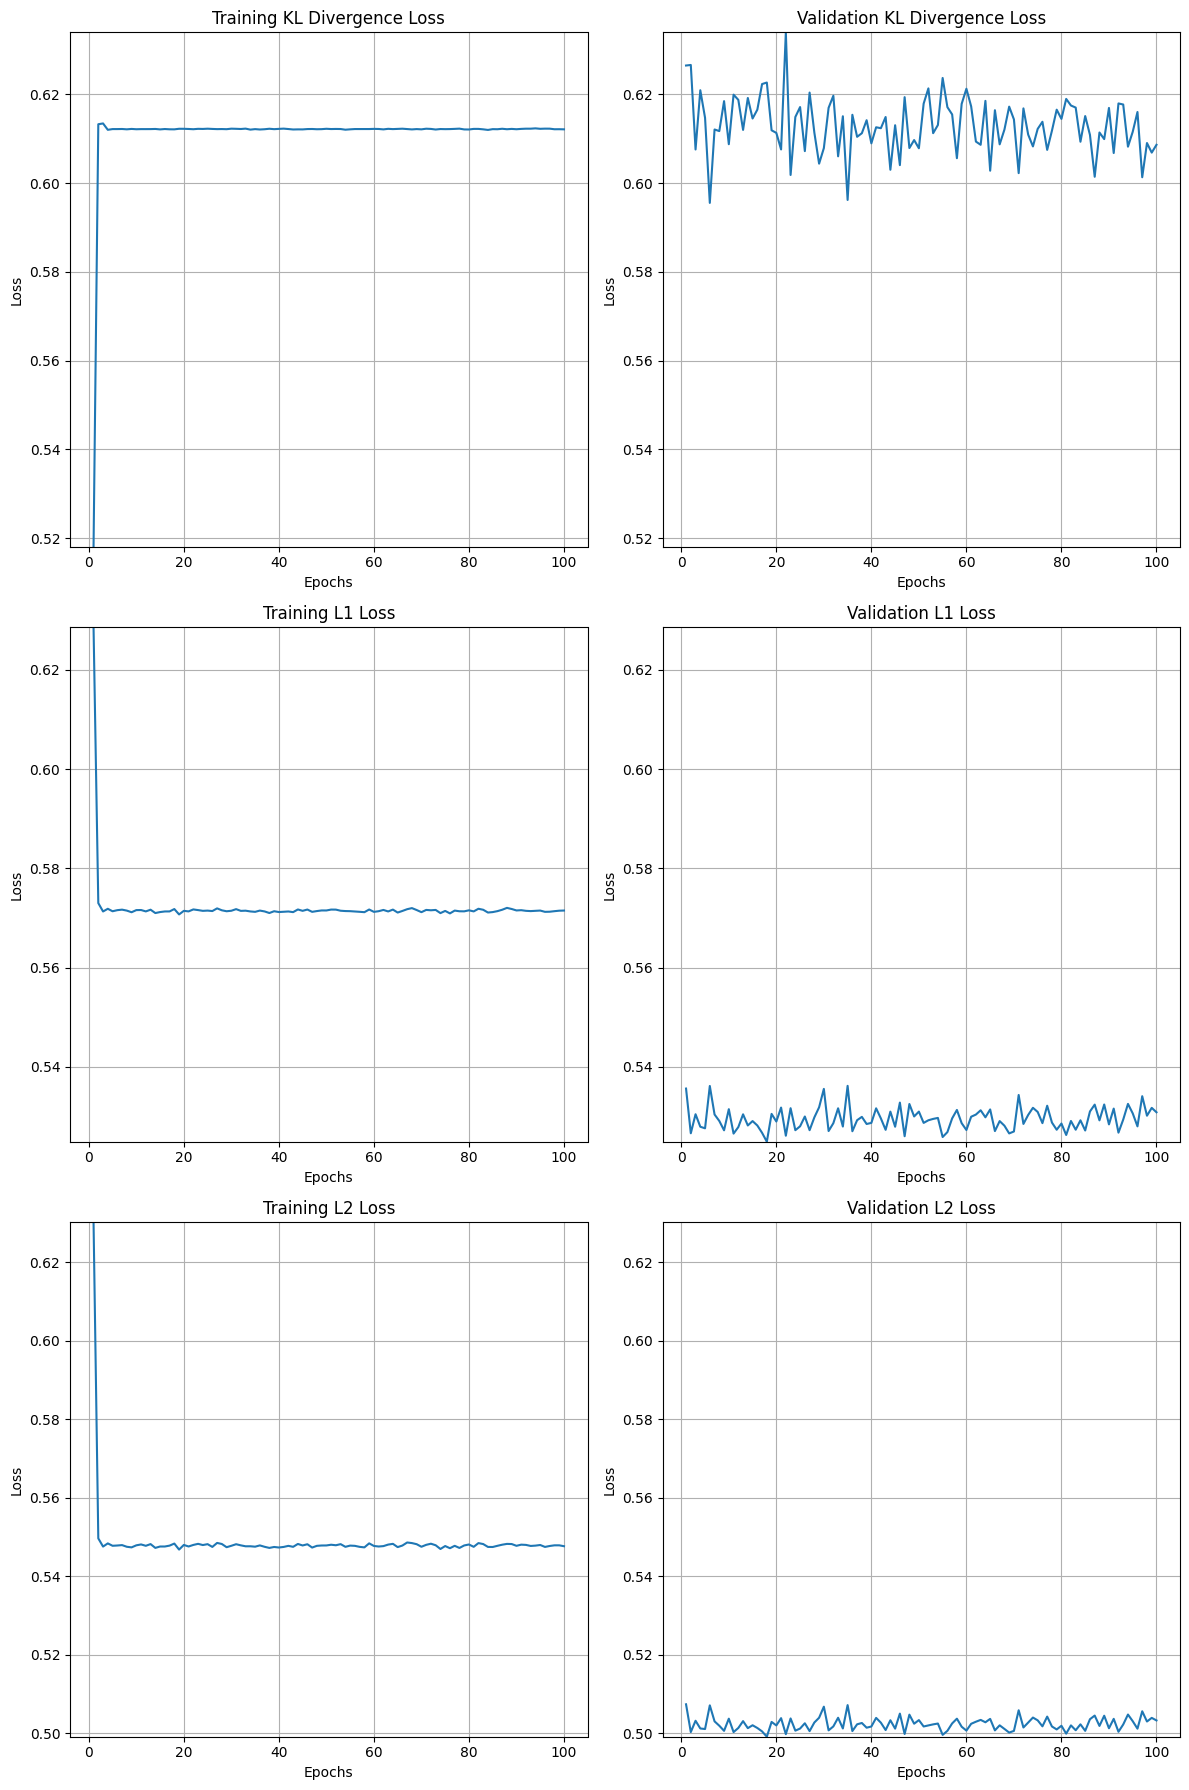

Best Validation Loss in Kelvins:
50.8666 K


In [7]:
# * * * * * * * * * * * * * * * *
# Train and Validate
# * * * * * * * * * * * * * * * *
losses = train(
	vae, train_loader, val_loader,
	optimizer, scheduler, DEVICE, EPOCHS,
	BETA, model_dir)

# Plot losses
PlotLosses(losses, EPOCHS, model_dir)

# Save losses
SaveLossesToCSV(losses, os.path.join(model_dir, "losses.csv"))

PrintAndLog(log_filepath, "Best Validation Loss in Kelvins:\n")
PrintAndLog(
	log_filepath,
	f"\t{min(losses['val_l1_losses'])*x_data_std:.4f} K\n")

In [8]:
# * * * * * * * * * * * * * * * *
# Sample
# * * * * * * * * * * * * * * * *
z_sample = SampleLatentSpace(
	vae,
	test_loader,
	scaler,
	DEVICE,
	model_dir
)

[Sampling]: 100%|██████████| 5/5 [00:09<00:00,  1.94s/it]


z0: -0.0108
z1: -0.0572
z2: -0.0282
z3: 0.0257


Traversing Latent Dimension z3: 100%|██████████| 11/11 [00:00<00:00, 681.33it/s]


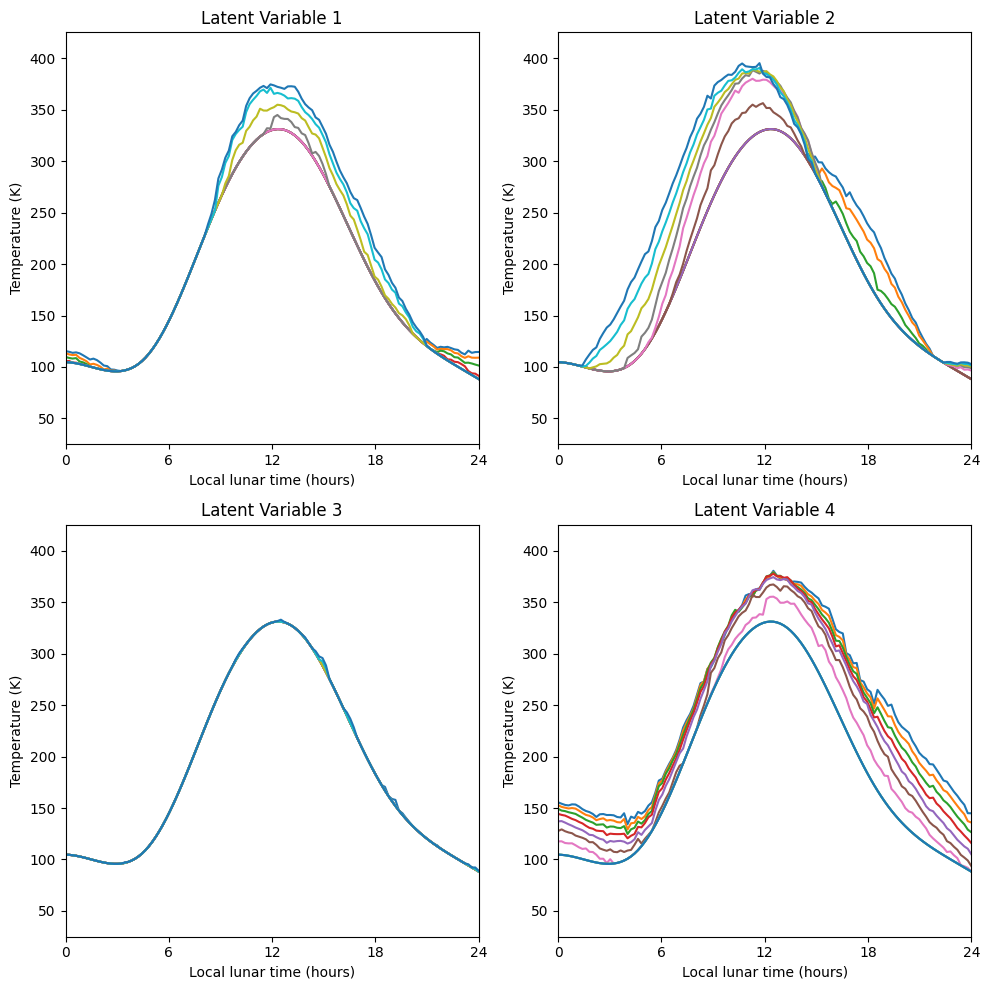

In [9]:
# * * * * * * * * * * * * * * * *
# Analyze Latent Space
# * * * * * * * * * * * * * * * *
mean_latent_vals = GetMeanLatentValues(z_sample, LATENT_DIM)
for i in range(LATENT_DIM):
	print(f"z{i}: {mean_latent_vals[i]:.4f}")

VisualizeLatentSpace(
	vae, LATENT_DIM, z_sample,
	scaler, DEVICE, model_dir)